✅ Session Ended


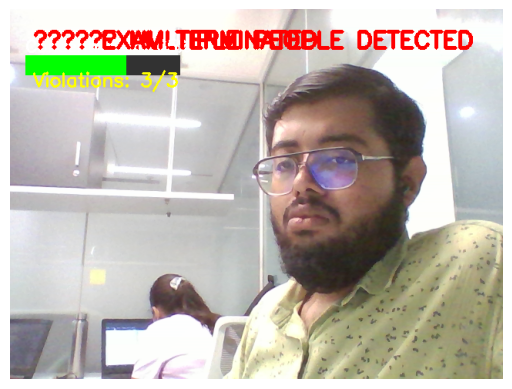

In [8]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
from ultralytics import YOLO
from datetime import datetime
import os
from collections import deque

# Load your custom YOLO model for phones
yolo_custom = YOLO(r"C:\Users\sagni\runs\detect\custom_phone_model4\weights\best.pt")

# Load COCO YOLOv8 model for people detection
yolo_people = YOLO('yolov8n.pt')

# Mediapipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True, max_num_faces=2)
mp_drawing = mp.solutions.drawing_utils

# Eye and iris landmarks
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
LEFT_IRIS = 468
RIGHT_IRIS = 473

# Buffer for smoothing
score_buffer = deque(maxlen=10)

# Folder for alerts
if not os.path.exists("alerts"):
    os.makedirs("alerts")

def save_violation(frame, reason="violation"):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"alerts/{reason}_{timestamp}.jpg"
    cv2.imwrite(filename, frame)
    print(f"📸 Saved screenshot: {filename}")

def detect_custom_objects(frame):
    """Detect phones and other objects with custom YOLO"""
    return yolo_custom.predict(frame, imgsz=640, conf=0.3, verbose=False)[0]

def detect_people(frame):
    """Detect people using COCO YOLO"""
    result = yolo_people.predict(frame, imgsz=640, conf=0.3, verbose=False)[0]
    return sum(1 for box in result.boxes
               if result.names[int(box.cls[0])].lower() == "person")

def calculate_ear(landmarks, eye_indices, w, h):
    pts = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in eye_indices]
    v1 = np.linalg.norm(np.array(pts[1]) - np.array(pts[5]))
    v2 = np.linalg.norm(np.array(pts[2]) - np.array(pts[4]))
    hdist = np.linalg.norm(np.array(pts[0]) - np.array(pts[3]))
    return (v1 + v2) / (2.0 * hdist)

def is_blink(ear, threshold=0.21):
    return ear < threshold

def get_gaze(landmarks):
    lx, rx = landmarks[LEFT_IRIS].x, landmarks[RIGHT_IRIS].x
    ly, ry = landmarks[LEFT_IRIS].y, landmarks[RIGHT_IRIS].y
    avg_x, avg_y = (lx + rx) / 2, (ly + ry) / 2
    if 0.4 < avg_x < 0.6 and 0.4 < avg_y < 0.6:
        return 1.0
    elif 0.3 < avg_x < 0.7 and 0.3 < avg_y < 0.7:
        return 0.5
    return 0.0

def compute_concentration(gaze, blink):
    return round((0.7 * gaze + 0.3 * (0 if blink else 1)) * 100, 1)

def draw_alert(frame, text, color=(0, 0, 255)):
    cv2.putText(frame, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

def draw_score_bar(frame, score):
    cv2.rectangle(frame, (20, 60), (220, 85), (50, 50, 50), -1)
    fill = int(score / 100 * 200)
    color = (0, 255, 0) if score >= 40 else (0, 128, 255)
    cv2.rectangle(frame, (20, 60), (20 + fill, 85), color, -1)
    cv2.putText(frame, f"Concentration: {score}%", (20, 55),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

def show_frame_in_notebook(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

def main():
    violation_count = 0
    distraction_count = 0
    MAX_WARNINGS = 3
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("❌ Webcam access failed")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)
            h, w, _ = frame.shape
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_results = face_mesh.process(frame_rgb)

            # Detect phones and objects with custom YOLO
            custom_results = detect_custom_objects(frame)
            labels = [custom_results.names[int(box.cls[0])].lower() for box in custom_results.boxes]
            print(f"Custom model detections: {labels}")

            # Detect people with COCO YOLO
            people_count = detect_people(frame)
            print(f"People detected: {people_count}")

            if people_count > 1:
                draw_alert(frame, "⚠️ MULTIPLE PEOPLE DETECTED")
                save_violation(frame, "multiple_people")
                violation_count += 1

            # Prohibited objects
            prohibited_labels = ['cell phone', 'mobile phone', 'phone', 'smartphone', 'book', 'laptop', 'remote']
            if any(lbl in prohibited_labels for lbl in labels):
                draw_alert(frame, "⚠️ PROHIBITED OBJECT DETECTED")
                save_violation(frame, "prohibited_object")
                violation_count += 1

            # Face analysis
            if face_results.multi_face_landmarks:
                for landmarks_obj in face_results.multi_face_landmarks:
                    landmarks = landmarks_obj.landmark
                    ear_l = calculate_ear(landmarks, LEFT_EYE, w, h)
                    ear_r = calculate_ear(landmarks, RIGHT_EYE, w, h)
                    avg_ear = (ear_l + ear_r) / 2
                    blink = is_blink(avg_ear)
                    gaze = get_gaze(landmarks)

                    score = compute_concentration(gaze, blink)
                    score_buffer.append(score)
                    smooth = int(np.mean(score_buffer))
                    draw_score_bar(frame, smooth)

                    if smooth < 40:
                        distraction_count += 1
                        draw_alert(frame, f"⚠️ LOW CONCENTRATION ({distraction_count})", color=(0, 165, 255))
                        if distraction_count % 10 == 0:
                            save_violation(frame, "low_concentration")
                            violation_count += 1

            # Violation count
            cv2.putText(frame, f"Violations: {violation_count}/{MAX_WARNINGS}", (30, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

            # Stop after max warnings
            if violation_count >= MAX_WARNINGS:
                draw_alert(frame, "🛑 EXAM TERMINATED")
                save_violation(frame, "exam_terminated")
                show_frame_in_notebook(frame)
                break

            show_frame_in_notebook(frame)
            time.sleep(0.05)

    finally:
        cap.release()
        print("✅ Session Ended")

main()


✅ Session Ended


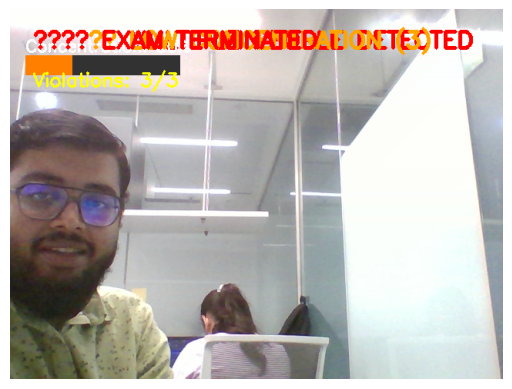

In [17]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
from ultralytics import YOLO
from datetime import datetime
import os
from collections import deque

yolo_custom = YOLO(r"C:\Users\sagni\runs\detect\custom_phone_model4\weights\best.pt")
yolo_people = YOLO('yolov8n.pt')

print("📦 Custom model classes:", yolo_custom.names)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True, max_num_faces=2)
mp_drawing = mp.solutions.drawing_utils

LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
LEFT_IRIS = 468
RIGHT_IRIS = 473

score_buffer = deque(maxlen=10)

if not os.path.exists("alerts"):
    os.makedirs("alerts")

def save_violation(frame, reason="violation"):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"alerts/{reason}_{timestamp}.jpg"
    cv2.imwrite(filename, frame)
    print(f"📸 Saved screenshot: {filename}")

def detect_custom_objects(frame):
    """Detect phones and other objects with custom YOLO"""
    return yolo_custom.predict(frame, imgsz=640, conf=0.2, verbose=False)[0]

def detect_people_and_coco_phones(frame):
    """Detect people and phones using COCO YOLO"""
    result = yolo_people.predict(frame, imgsz=640, conf=0.3, verbose=False)[0]
    people_count = sum(1 for box in result.boxes
                       if result.names[int(box.cls[0])].lower() == "person")
    coco_phone_detected = any(result.names[int(box.cls[0])].lower() in ['cell phone', 'mobile phone', 'phone']
                              for box in result.boxes)
    return people_count, coco_phone_detected

def calculate_ear(landmarks, eye_indices, w, h):
    pts = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in eye_indices]
    v1 = np.linalg.norm(np.array(pts[1]) - np.array(pts[5]))
    v2 = np.linalg.norm(np.array(pts[2]) - np.array(pts[4]))
    hdist = np.linalg.norm(np.array(pts[0]) - np.array(pts[3]))
    return (v1 + v2) / (2.0 * hdist)

def is_blink(ear, threshold=0.21):
    return ear < threshold

def get_gaze(landmarks):
    lx, rx = landmarks[LEFT_IRIS].x, landmarks[RIGHT_IRIS].x
    ly, ry = landmarks[LEFT_IRIS].y, landmarks[RIGHT_IRIS].y
    avg_x, avg_y = (lx + rx) / 2, (ly + ry) / 2
    if 0.4 < avg_x < 0.6 and 0.4 < avg_y < 0.6:
        return 1.0
    elif 0.3 < avg_x < 0.7 and 0.3 < avg_y < 0.7:
        return 0.5
    return 0.0

def compute_concentration(gaze, blink):
    return round((0.7 * gaze + 0.3 * (0 if blink else 1)) * 100, 1)

def draw_alert(frame, text, color=(0, 0, 255)):
    cv2.putText(frame, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

def draw_score_bar(frame, score):
    cv2.rectangle(frame, (20, 60), (220, 85), (50, 50, 50), -1)
    fill = int(score / 100 * 200)
    color = (0, 255, 0) if score >= 40 else (0, 128, 255)
    cv2.rectangle(frame, (20, 60), (20 + fill, 85), color, -1)
    cv2.putText(frame, f"Concentration: {score}%", (20, 55),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

def show_frame_in_notebook(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

def main():
    violation_count = 0
    distraction_count = 0
    MAX_WARNINGS = 3
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("❌ Webcam access failed")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)
            h, w, _ = frame.shape
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_results = face_mesh.process(frame_rgb)

            custom_results = detect_custom_objects(frame)
            custom_labels = [yolo_custom.names[int(box.cls[0])].lower() for box in custom_results.boxes]
            print(f"📦 Custom model detections: {custom_labels}")

            people_count, coco_phone_detected = detect_people_and_coco_phones(frame)
            print(f"👥 People detected: {people_count}, 📱 COCO phone detected: {coco_phone_detected}")

            if people_count > 1:
                draw_alert(frame, "⚠️ MULTIPLE PEOPLE DETECTED")
                save_violation(frame, "multiple_people")
                violation_count += 1

            if any(lbl in ['phone', 'mobile phone', 'cell phone'] for lbl in custom_labels) or coco_phone_detected:
                draw_alert(frame, "⚠️ PHONE DETECTED")
                save_violation(frame, "phone_detected")
                violation_count += 1

            if face_results.multi_face_landmarks:
                for landmarks_obj in face_results.multi_face_landmarks:
                    landmarks = landmarks_obj.landmark
                    ear_l = calculate_ear(landmarks, LEFT_EYE, w, h)
                    ear_r = calculate_ear(landmarks, RIGHT_EYE, w, h)
                    avg_ear = (ear_l + ear_r) / 2
                    blink = is_blink(avg_ear)
                    gaze = get_gaze(landmarks)

                    score = compute_concentration(gaze, blink)
                    score_buffer.append(score)
                    smooth = int(np.mean(score_buffer))
                    draw_score_bar(frame, smooth)

                    if smooth < 40:
                        distraction_count += 1
                        draw_alert(frame, f"⚠️ LOW CONCENTRATION ({distraction_count})", color=(0, 165, 255))
                        if distraction_count % 10 == 0:
                            save_violation(frame, "low_concentration")
                            violation_count += 1

            cv2.putText(frame, f"Violations: {violation_count}/{MAX_WARNINGS}", (30, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

            if violation_count >= MAX_WARNINGS:
                draw_alert(frame, "🛑 EXAM TERMINATED")
                save_violation(frame, "exam_terminated")
                show_frame_in_notebook(frame)
                break

            show_frame_in_notebook(frame)
            time.sleep(0.05)

    finally:
        cap.release()
        print("✅ Session Ended")

main()
